In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")


All libraries imported successfully!


In [2]:
# Load the dataset with latin-1 encoding
df = pd.read_csv('AB_NYC_2019.csv', index_col=False)

# Display basic information
print("=" * 60)
print("DATASET SHAPE & BASIC INFO")
print("=" * 60)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

print("Column Names & Data Types:")
print(df.dtypes)

print("\n" + "=" * 60)
print("FIRST 5 ROWS")
print("=" * 60)
print(df.head())

print("\n" + "=" * 60)
print("DATASET INFO")
print("=" * 60)
df.info()




DATASET SHAPE & BASIC INFO
Shape: 48895 rows × 16 columns

Column Names & Data Types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

FIRST 5 ROWS
     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3

MISSING VALUES ANALYSIS
                              Column  Missing_Count  Missing_Percentage  \
reviews_per_month  reviews_per_month          10052               20.56   
last_review              last_review          10052               20.56   
host_name                  host_name             21                0.04   
name                            name             16                0.03   

                  Data_Type  
reviews_per_month   float64  
last_review          object  
host_name            object  
name                 object  


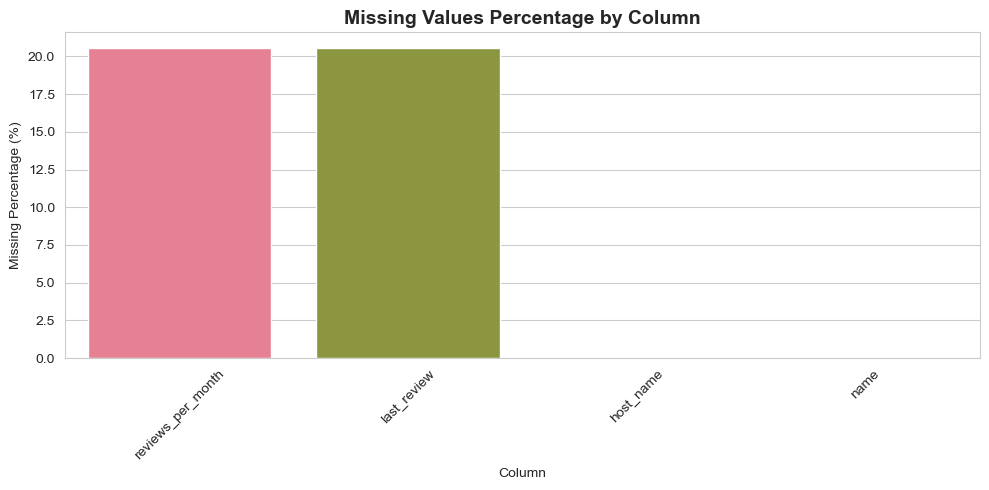

In [3]:
# Comprehensive missing value analysis
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_data)

# Visualize missing values
if len(missing_data) > 0:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=missing_data, x='Column', y='Missing_Percentage', palette='husl')
    plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.ylabel('Missing Percentage (%)')
    plt.tight_layout()
    plt.savefig('01_missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()


In [4]:
# Create a copy for cleaning
df_clean = df.copy()

# 1. Handle missing values
print("Handling missing values...")

df_clean['last_review'] = df_clean['last_review'].fillna('No reviews')
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)
df_clean['name'] = df_clean['name'].fillna('Unnamed Listing')

print("Missing values handled\n")

# 2. Remove duplicates
print("Removing duplicates...")
duplicates_before = len(df_clean)
df_clean = df_clean.drop_duplicates(subset=['id'], keep='first')
duplicates_removed = duplicates_before - len(df_clean)
print(f"Removed {duplicates_removed} duplicate rows\n")

# 3. Handle outliers in price
print("Handling outliers...")

Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Price Range (IQR Method): ${lower_bound:.2f} - ${upper_bound:.2f}")
print(f"Listings outside range: {len(df_clean[(df_clean['price'] < lower_bound) | (df_clean['price'] > upper_bound)])}")

df_clean['is_outlier'] = ((df_clean['price'] < lower_bound) | (df_clean['price'] > upper_bound))
print(f"Outliers flagged\n")

# 4. Data type conversions
print("Data type conversions...")
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'], errors='coerce')
df_clean['id'] = df_clean['id'].astype(str)
print("Data types converted\n")

# Save cleaned data
df_clean.to_csv('data/cleaned/airbnb_cleaned.csv', index=False)
print("Cleaned data saved!")

print("\n" + "=" * 60)
print("CLEANING SUMMARY")
print("=" * 60)
print(f"Original shape: {df.shape}")
print(f"Cleaned shape: {df_clean.shape}")
print(f"Rows removed: {df.shape[0] - df_clean.shape[0]}")


Handling missing values...
Missing values handled

Removing duplicates...
Removed 0 duplicate rows

Handling outliers...
Price Range (IQR Method): $-90.00 - $334.00
Listings outside range: 2972
Outliers flagged

Data type conversions...
Data types converted

Cleaned data saved!

CLEANING SUMMARY
Original shape: (48895, 16)
Cleaned shape: (48895, 17)
Rows removed: 0


In [5]:
# Load cleaned data if not already in memory
df = pd.read_csv('data/cleaned/airbnb_cleaned.csv')

print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)

# Numeric columns statistics
numeric_stats = df.describe().T
numeric_stats['non_null'] = df.count()
print("\nNUMERIC COLUMNS STATISTICS:")
print(numeric_stats)

# Categorical columns statistics
print("\n" + "=" * 80)
print("CATEGORICAL COLUMNS UNIQUE VALUES:")
print("=" * 80)

categorical_cols = ['neighbourhood_group', 'room_type', 'name']
for col in categorical_cols:
    print(f"\n{col.upper()}: {df[col].nunique()} unique values")
    print(df[col].value_counts())


DESCRIPTIVE STATISTICS

NUMERIC COLUMNS STATISTICS:
                                  count          mean           std  \
id                              48895.0  1.901714e+07  1.098311e+07   
host_id                         48895.0  6.762001e+07  7.861097e+07   
latitude                        48895.0  4.072895e+01  5.453008e-02   
longitude                       48895.0 -7.395217e+01  4.615674e-02   
price                           48895.0  1.527207e+02  2.401542e+02   
minimum_nights                  48895.0  7.029962e+00  2.051055e+01   
number_of_reviews               48895.0  2.327447e+01  4.455058e+01   
reviews_per_month               48895.0  1.090910e+00  1.597283e+00   
calculated_host_listings_count  48895.0  7.143982e+00  3.295252e+01   
availability_365                48895.0  1.127813e+02  1.316223e+02   

                                       min           25%           50%  \
id                              2539.00000  9.471945e+06  1.967728e+07   
host_id           

In [6]:
print("=" * 80)
print("NEIGHBORHOOD ANALYSIS")
print("=" * 80)

# Listings by neighbourhood group
print("\nListings by neighbourhood group:")
neighbourhood_counts = df['neighbourhood_group'].value_counts().sort_values(ascending=False)
print(neighbourhood_counts)

# Price statistics by neighbourhood group
print("\nPrice statistics by neighbourhood group:")
price_by_neighbourhood = df.groupby('neighbourhood_group')['price'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
price_by_neighbourhood.columns = ['Count', 'Mean Price', 'Median Price', 'Std Dev', 'Min', 'Max']
print(price_by_neighbourhood)

# Availability by neighbourhood group
print("\nAvailability by neighbourhood group:")
avail_by_neighbourhood = df.groupby('neighbourhood_group')['availability_365'].agg([
    'mean', 'median', 'std'
]).round(2)
avail_by_neighbourhood.columns = ['Mean Availability', 'Median Availability', 'Std Dev']
print(avail_by_neighbourhood)

# Reviews by neighbourhood group
print("\nReviews per month by neighbourhood group:")
reviews_by_neighbourhood = df.groupby('neighbourhood_group')['reviews_per_month'].agg([
    'count', 'mean', 'median'
]).round(2)
reviews_by_neighbourhood.columns = ['Count', 'Mean Reviews/Month', 'Median Reviews/Month']
print(reviews_by_neighbourhood)


NEIGHBORHOOD ANALYSIS

Listings by neighbourhood group:
neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

Price statistics by neighbourhood group:
                     Count  Mean Price  Median Price  Std Dev  Min    Max
neighbourhood_group                                                      
Bronx                 1091       87.50          65.0   106.71    0   2500
Brooklyn             20104      124.38          90.0   186.87    0  10000
Manhattan            21661      196.88         150.0   291.38    0  10000
Queens                5666       99.52          75.0   167.10   10  10000
Staten Island          373      114.81          75.0   277.62   13   5000

Availability by neighbourhood group:
                     Mean Availability  Median Availability  Std Dev
neighbourhood_group                                                 
Bronx                           165.76         

In [7]:
print("=" * 80)
print("ROOM TYPE ANALYSIS")
print("=" * 80)

# Room type distribution
print("\nRoom type distribution:")
room_type_counts = df['room_type'].value_counts()
print(room_type_counts)
print(f"\nPercentages:")
print((room_type_counts / len(df) * 100).round(2))

# Price by room type
print("\nPrice statistics by room type:")
price_by_room = df.groupby('room_type')['price'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)
price_by_room.columns = ['Count', 'Mean Price', 'Median Price', 'Std Dev', 'Min', 'Max']
print(price_by_room)

# Reviews by room type
print("\nReviews per month by room type:")
reviews_by_room = df.groupby('room_type')['reviews_per_month'].agg([
    'mean', 'median', 'std'
]).round(2)
reviews_by_room.columns = ['Mean Reviews/Month', 'Median Reviews/Month', 'Std Dev']
print(reviews_by_room)

# Room type by neighbourhood
print("\nRoom type distribution by neighbourhood:")
room_neighbourhood = pd.crosstab(df['neighbourhood_group'], df['room_type'], margins=True)
print(room_neighbourhood)


ROOM TYPE ANALYSIS

Room type distribution:
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

Percentages:
room_type
Entire home/apt    51.97
Private room       45.66
Shared room         2.37
Name: count, dtype: float64

Price statistics by room type:
                 Count  Mean Price  Median Price  Std Dev  Min    Max
room_type                                                            
Entire home/apt  25409      211.79         160.0   284.04    0  10000
Private room     22326       89.78          70.0   160.21    0  10000
Shared room       1160       70.13          45.0   101.73    0   1800

Reviews per month by room type:
                 Mean Reviews/Month  Median Reviews/Month  Std Dev
room_type                                                         
Entire home/apt                1.05                  0.35     1.49
Private room                   1.14                  0.40     1.72
Shared room                    1.07

In [8]:
print("=" * 80)
print("PRICE DISTRIBUTION ANALYSIS")
print("=" * 80)

print(f"Price Range: ${df['price'].min():.2f} - ${df['price'].max():.2f}")
print(f"Mean Price: ${df['price'].mean():.2f}")
print(f"Median Price: ${df['price'].median():.2f}")
print(f"Mode Price: ${df['price'].mode().iloc[0]:.2f}")  # FIXED LINE
print(f"Standard Deviation: ${df['price'].std():.2f}")

# Percentiles
print("\nPrice Percentiles:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = df['price'].quantile(p/100)
    print(f"{p}th percentile: ${value:.2f}")

# Distribution without extreme outliers
price_filtered = df[df['price'] <= df['price'].quantile(0.95)]['price']
print(f"\nPrice stats (excluding top 5% outliers):")
print(f"Max Price (95%): ${price_filtered.max():.2f}")
print(f"Mean Price: ${price_filtered.mean():.2f}")


PRICE DISTRIBUTION ANALYSIS
Price Range: $0.00 - $10000.00
Mean Price: $152.72
Median Price: $106.00
Mode Price: $100.00
Standard Deviation: $240.15

Price Percentiles:
10th percentile: $49.00
25th percentile: $69.00
50th percentile: $106.00
75th percentile: $175.00
90th percentile: $269.00
95th percentile: $355.00
99th percentile: $799.00

Price stats (excluding top 5% outliers):
Max Price (95%): $355.00
Mean Price: $122.58


In [9]:
print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numeric columns
numeric_df = df[['price', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights']].copy()

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()
print("\nCORRELATION MATRIX:")
print(correlation_matrix.round(3))

# Find strong correlations (excluding diagonal)
print("\nSTRONG CORRELATIONS (|r| > 0.3):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.3:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            print(f"{col1} <-> {col2}: {corr_value:.3f}")


CORRELATION ANALYSIS

CORRELATION MATRIX:
                   price  number_of_reviews  reviews_per_month  \
price              1.000             -0.048             -0.051   
number_of_reviews -0.048              1.000              0.589   
reviews_per_month -0.051              0.589              1.000   
availability_365   0.082              0.172              0.164   
minimum_nights     0.043             -0.080             -0.125   

                   availability_365  minimum_nights  
price                         0.082           0.043  
number_of_reviews             0.172          -0.080  
reviews_per_month             0.164          -0.125  
availability_365              1.000           0.144  
minimum_nights                0.144           1.000  

STRONG CORRELATIONS (|r| > 0.3):
number_of_reviews <-> reviews_per_month: 0.589


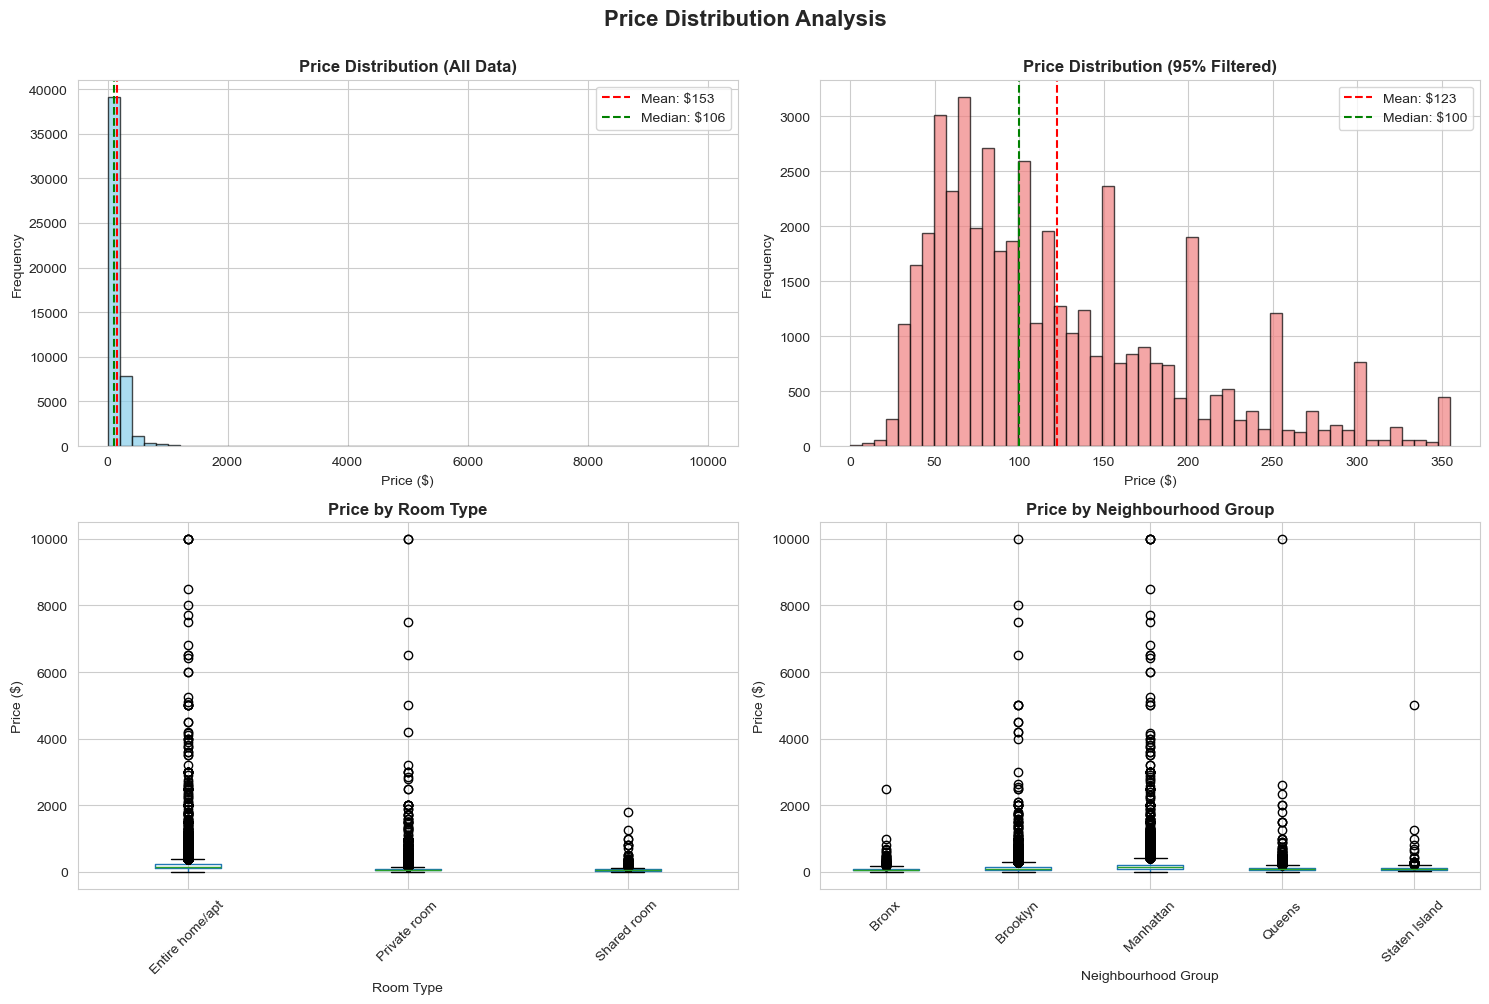

Price distribution visualizations saved!


In [10]:
# Create comprehensive price distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histogram of all prices
axes[0, 0].hist(df['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Price ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Distribution (All Data)', fontweight='bold')
axes[0, 0].axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():.0f}')
axes[0, 0].axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: ${df["price"].median():.0f}')
axes[0, 0].legend()

# 2. Histogram of prices (filtered - 95th percentile)
price_95 = df[df['price'] <= df['price'].quantile(0.95)]['price']
axes[0, 1].hist(price_95, bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Price Distribution (95% Filtered)', fontweight='bold')
axes[0, 1].axvline(price_95.mean(), color='red', linestyle='--', label=f'Mean: ${price_95.mean():.0f}')
axes[0, 1].axvline(price_95.median(), color='green', linestyle='--', label=f'Median: ${price_95.median():.0f}')
axes[0, 1].legend()

# 3. Box plot by room type
df.boxplot(column='price', by='room_type', ax=axes[1, 0])
axes[1, 0].set_xlabel('Room Type')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price by Room Type', fontweight='bold')
plt.sca(axes[1, 0])
plt.xticks(rotation=45)

# 4. Box plot by neighbourhood group
df.boxplot(column='price', by='neighbourhood_group', ax=axes[1, 1])
axes[1, 1].set_xlabel('Neighbourhood Group')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price by Neighbourhood Group', fontweight='bold')
plt.sca(axes[1, 1])
plt.xticks(rotation=45)

plt.suptitle('Price Distribution Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('visualizations/02_price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Price distribution visualizations saved!")


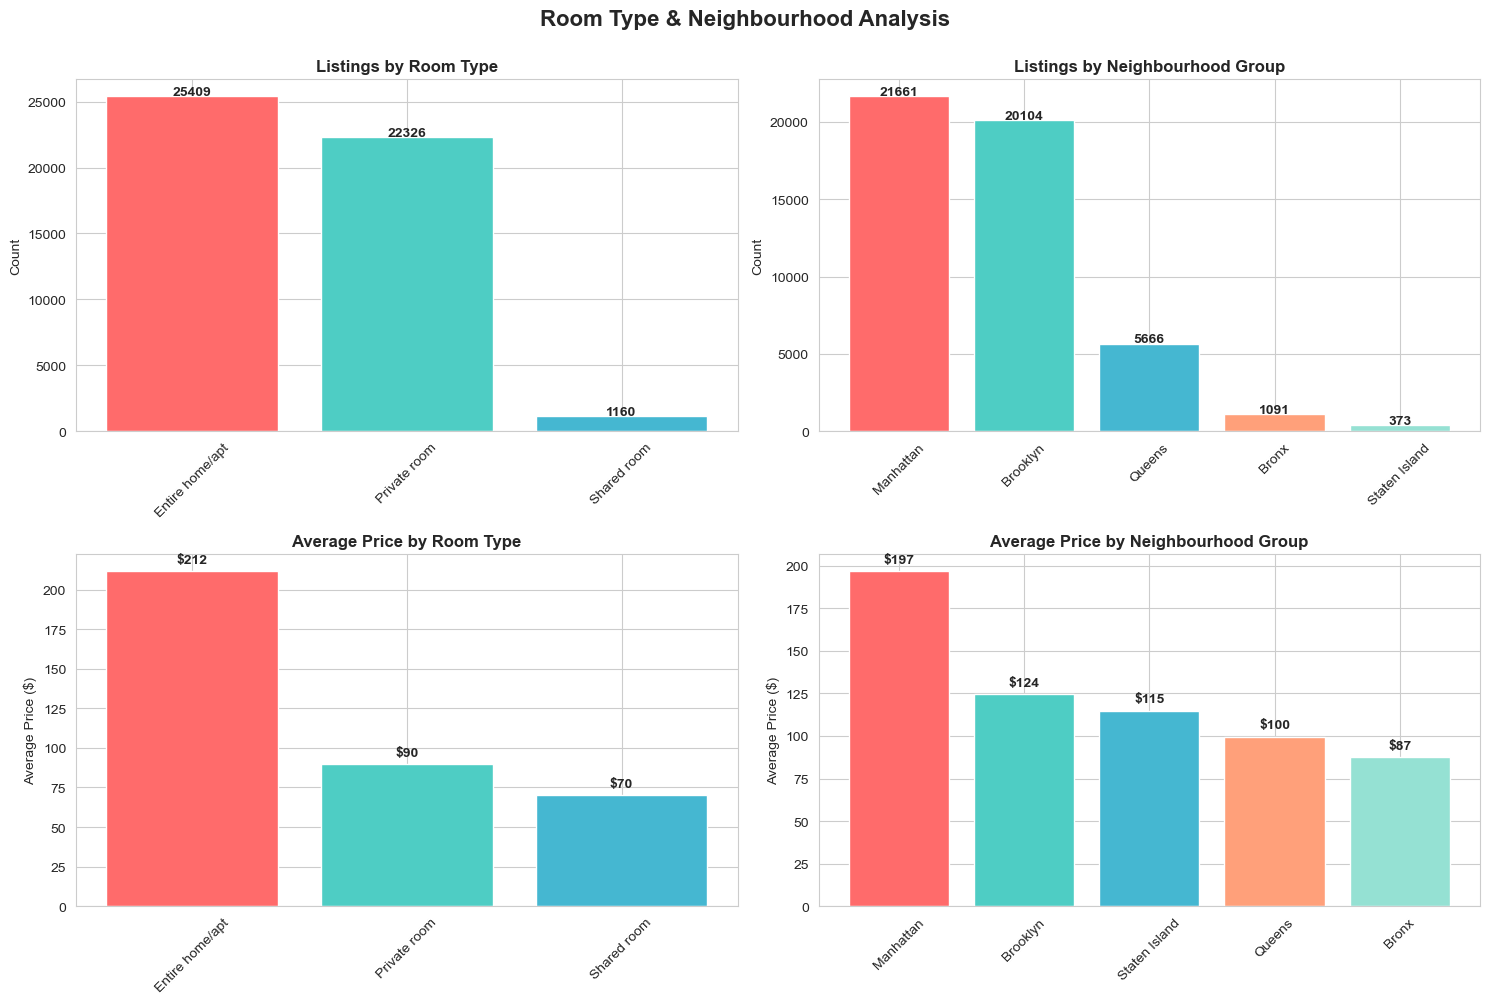

Room type and neighbourhood visualizations saved!


In [11]:
# Room type and neighbourhood analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Room type count
room_counts = df['room_type'].value_counts()
axes[0, 0].bar(room_counts.index, room_counts.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Listings by Room Type', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(room_counts.values):
    axes[0, 0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# 2. Neighbourhood group count
neighbourhood_counts = df['neighbourhood_group'].value_counts()
colors_neighbourhood = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
axes[0, 1].bar(neighbourhood_counts.index, neighbourhood_counts.values, color=colors_neighbourhood[:len(neighbourhood_counts)])
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Listings by Neighbourhood Group', fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(neighbourhood_counts.values):
    axes[0, 1].text(i, v + 100, str(v), ha='center', fontweight='bold')

# 3. Average price by room type
avg_price_room = df.groupby('room_type')['price'].mean().sort_values(ascending=False)
axes[1, 0].bar(avg_price_room.index, avg_price_room.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'])
axes[1, 0].set_ylabel('Average Price ($)')
axes[1, 0].set_title('Average Price by Room Type', fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(avg_price_room.values):
    axes[1, 0].text(i, v + 5, f'${v:.0f}', ha='center', fontweight='bold')

# 4. Average price by neighbourhood group
avg_price_neighbourhood = df.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
axes[1, 1].bar(avg_price_neighbourhood.index, avg_price_neighbourhood.values, color=colors_neighbourhood[:len(avg_price_neighbourhood)])
axes[1, 1].set_ylabel('Average Price ($)')
axes[1, 1].set_title('Average Price by Neighbourhood Group', fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(avg_price_neighbourhood.values):
    axes[1, 1].text(i, v + 5, f'${v:.0f}', ha='center', fontweight='bold')

plt.suptitle('Room Type & Neighbourhood Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('visualizations/03_room_neighbourhood.png', dpi=300, bbox_inches='tight')
plt.show()

print("Room type and neighbourhood visualizations saved!")


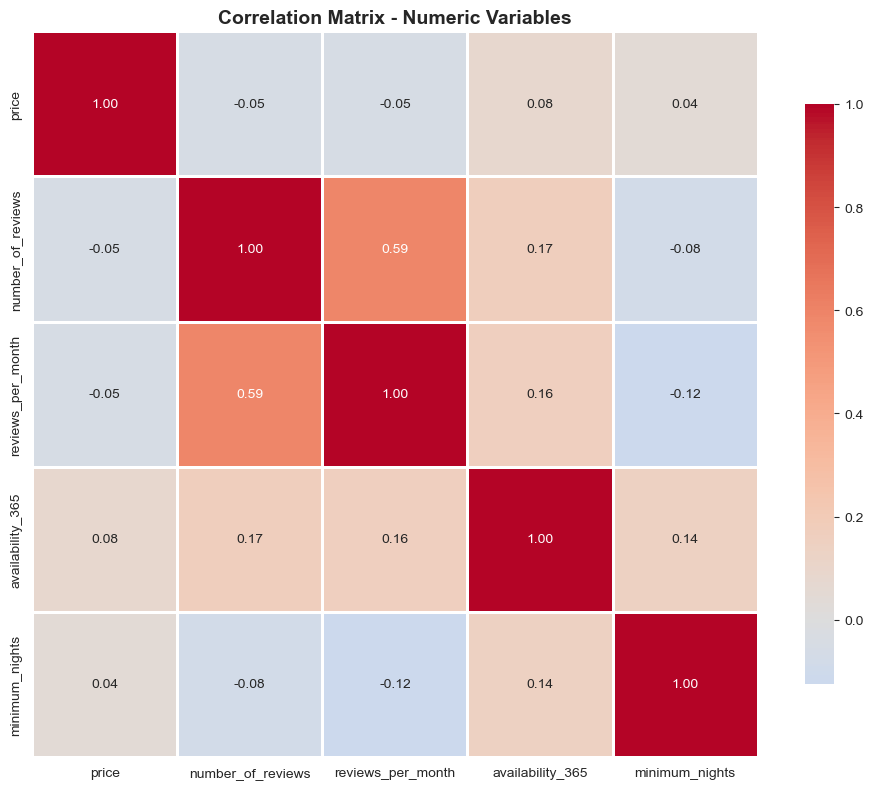

Correlation heatmap saved!


In [12]:
# Correlation heatmap
plt.figure(figsize=(10, 8))

numeric_df = df[['price', 'number_of_reviews', 'reviews_per_month', 'availability_365', 'minimum_nights']].copy()
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numeric Variables', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.savefig('visualizations/04_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Correlation heatmap saved!")


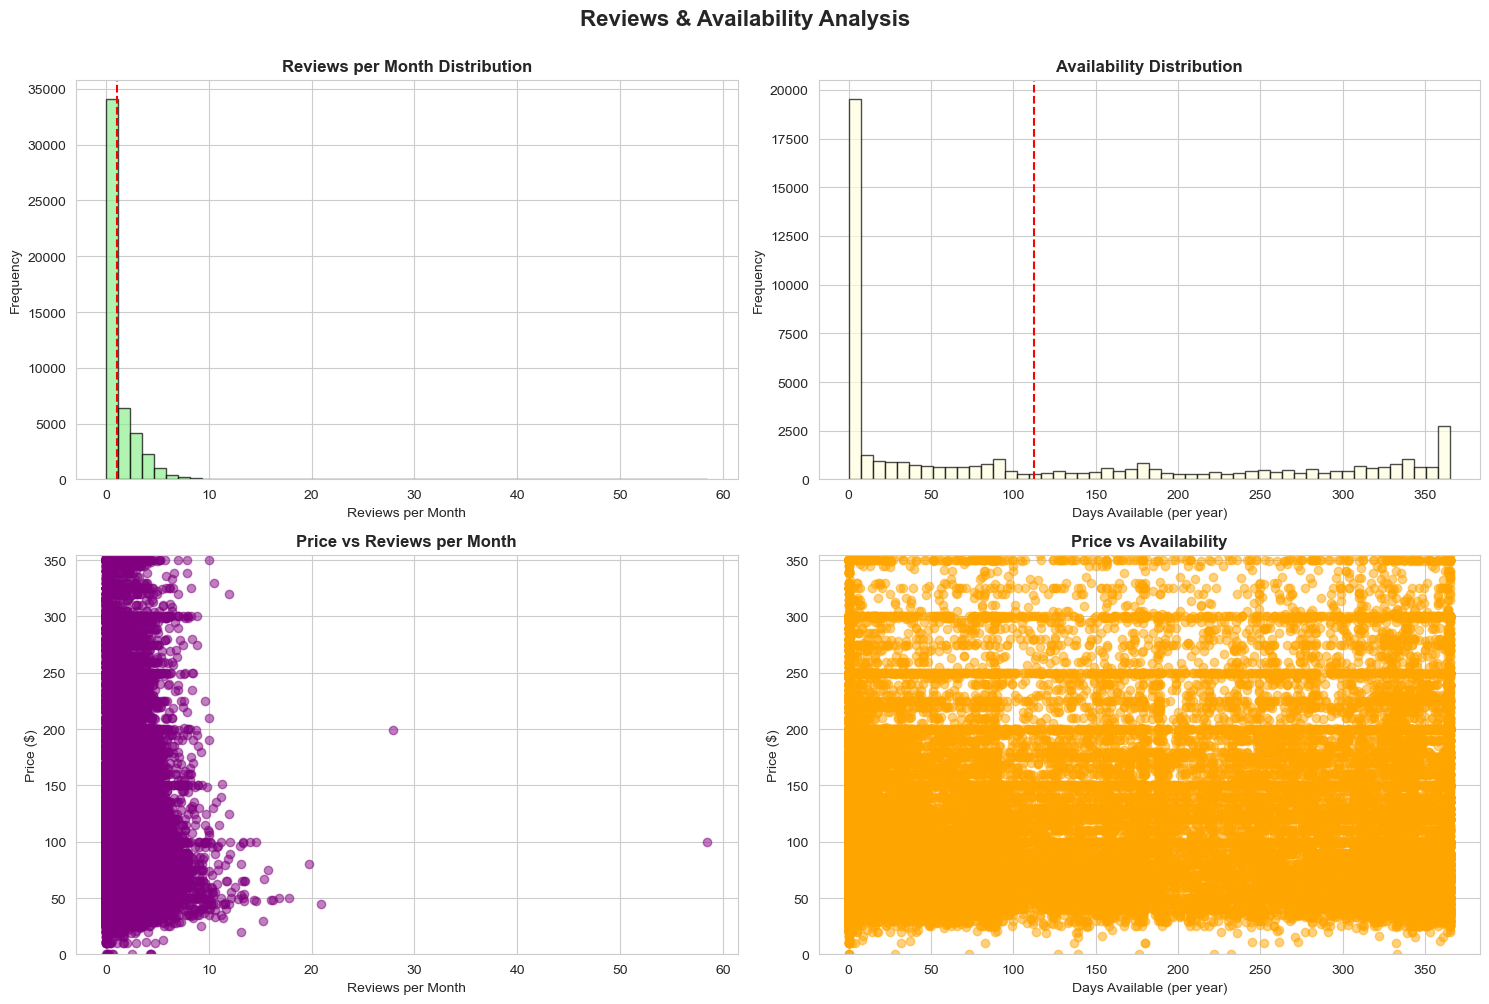

Reviews and availability visualizations saved!


In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Reviews per month distribution
axes[0, 0].hist(df['reviews_per_month'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Reviews per Month')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Reviews per Month Distribution', fontweight='bold')
axes[0, 0].axvline(df['reviews_per_month'].mean(), color='red', linestyle='--', label=f'Mean: {df["reviews_per_month"].mean():.2f}')

# 2. Availability distribution
axes[0, 1].hist(df['availability_365'], bins=50, color='lightyellow', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Days Available (per year)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Availability Distribution', fontweight='bold')
axes[0, 1].axvline(df['availability_365'].mean(), color='red', linestyle='--', label=f'Mean: {df["availability_365"].mean():.0f}')

# 3. Price vs Reviews per month scatter
axes[1, 0].scatter(df['reviews_per_month'], df['price'], alpha=0.5, color='purple')
axes[1, 0].set_xlabel('Reviews per Month')
axes[1, 0].set_ylabel('Price ($)')
axes[1, 0].set_title('Price vs Reviews per Month', fontweight='bold')
axes[1, 0].set_ylim([0, df['price'].quantile(0.95)])

# 4. Price vs Availability scatter
axes[1, 1].scatter(df['availability_365'], df['price'], alpha=0.5, color='orange')
axes[1, 1].set_xlabel('Days Available (per year)')
axes[1, 1].set_ylabel('Price ($)')
axes[1, 1].set_title('Price vs Availability', fontweight='bold')
axes[1, 1].set_ylim([0, df['price'].quantile(0.95)])

plt.suptitle('Reviews & Availability Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('visualizations/05_reviews_availability.png', dpi=300, bbox_inches='tight')
plt.show()

print("Reviews and availability visualizations saved!")


In [14]:
print("=" * 80)
print("ADVANCED PRICE INSIGHTS")
print("=" * 80)

# 1. Price per neighbourhood (top 15)
print("\nTop 15 most expensive neighbourhoods:")
price_by_neighbourhood_detailed = df.groupby('neighbourhood').agg({
    'price': ['mean', 'median', 'count'],
    'reviews_per_month': 'mean'
}).round(2)
price_by_neighbourhood_detailed.columns = ['Avg Price', 'Median Price', 'Count', 'Avg Reviews/Month']
price_by_neighbourhood_detailed = price_by_neighbourhood_detailed.sort_values('Avg Price', ascending=False)
print(price_by_neighbourhood_detailed.head(15))

# 2. Listings with minimum stay requirements
print("\nMinimum night analysis:")
min_night_stats = df['minimum_nights'].describe()
print(min_night_stats)

listings_high_min = len(df[df['minimum_nights'] > 30])
print(f"\nListings with minimum stay > 30 nights: {listings_high_min} ({listings_high_min/len(df)*100:.2f}%)")

# 3. Host activity analysis
print("\nHost activity analysis:")
print(f"Total unique hosts: {df['host_id'].nunique()}")
print(f"Average listings per host: {df.groupby('host_id').size().mean():.2f}")
print(f"Max listings by single host: {df.groupby('host_id').size().max()}")

# Hosts with most listings
top_hosts = df.groupby('host_id').size().sort_values(ascending=False).head(10)
print(f"\nTop 10 hosts by number of listings:")
print(top_hosts)


ADVANCED PRICE INSIGHTS

Top 15 most expensive neighbourhoods:
                   Avg Price  Median Price  Count  Avg Reviews/Month
neighbourhood                                                       
Fort Wadsworth        800.00         800.0      1               0.00
Woodrow               700.00         700.0      1               0.00
Tribeca               490.64         295.0    177               0.52
Sea Gate              487.86         125.0      7               0.19
Riverdale             442.09         150.0     11               0.84
Prince's Bay          409.50         151.5      4               0.94
Battery Park City     367.56         195.0     70               0.35
Flatiron District     341.92         225.0     80               0.91
Randall Manor         336.00          79.0     19               1.43
NoHo                  295.72         250.0     78               0.64
SoHo                  287.10         199.0    358               0.92
Midtown               282.72         210

In [15]:
print("\n" + "=" * 80)
print("KEY FINDINGS AND INSIGHTS")
print("=" * 80)

# Market Overview
print("\n1. MARKET OVERVIEW:")
print(f"   Total Listings: {len(df):,}")
print(f"   Total Hosts: {df['host_id'].nunique():,}")
print(f"   Average Listings per Host: {df.groupby('host_id').size().mean():.2f}")

# Price Insights
print("\n2. PRICE INSIGHTS:")
print(f"   Price Range: ${df['price'].min():.0f} - ${df['price'].max():.0f}")
print(f"   Average Price: ${df['price'].mean():.2f}")
print(f"   Median Price: ${df['price'].median():.2f}")
print(f"   Most Common Price: ${df['price'].mode().iloc[0]:.2f}") 

# Room Type Distribution
print("\n3. ROOM TYPE INSIGHTS:")
for room_type in df['room_type'].unique():
    count = len(df[df['room_type'] == room_type])
    avg_price = df[df['room_type'] == room_type]['price'].mean()
    pct = count / len(df) * 100
    print(f"   {room_type}: {count:,} listings ({pct:.1f}%), Avg Price: ${avg_price:.2f}")

# Neighbourhood Insights
print("\n4. NEIGHBOURHOOD INSIGHTS:")
for neighbourhood in df['neighbourhood_group'].unique():
    count = len(df[df['neighbourhood_group'] == neighbourhood])
    avg_price = df[df['neighbourhood_group'] == neighbourhood]['price'].mean()
    pct = count / len(df) * 100
    print(f"   {neighbourhood}: {count:,} listings ({pct:.1f}%), Avg Price: ${avg_price:.2f}")

# Review & Availability Insights
print("\n5. REVIEW & AVAILABILITY INSIGHTS:")
print(f"   Average Reviews per Month: {df['reviews_per_month'].mean():.2f}")
print(f"   Median Availability (days/year): {df['availability_365'].median():.0f}")
print(f"   Listings with no reviews: {len(df[df['number_of_reviews'] == 0]):,} ({len(df[df['number_of_reviews'] == 0])/len(df)*100:.2f}%)")

# Correlation Insights
print("\n6. CORRELATION INSIGHTS:")
print(f"   Price vs Reviews/Month: {df['price'].corr(df['reviews_per_month']):.3f}")
print(f"   Price vs Availability: {df['price'].corr(df['availability_365']):.3f}")
print(f"   Reviews/Month vs Availability: {df['reviews_per_month'].corr(df['availability_365']):.3f}")

# Outliers
outlier_count = len(df[df['is_outlier']])
print(f"\n7. OUTLIER ANALYSIS:")
print(f"   High-price outliers: {outlier_count:,} listings ({outlier_count/len(df)*100:.2f}%)")
print(f"   Top 5 most expensive listings: ${df.nlargest(5, 'price')['price'].values}")



KEY FINDINGS AND INSIGHTS

1. MARKET OVERVIEW:
   Total Listings: 48,895
   Total Hosts: 37,457
   Average Listings per Host: 1.31

2. PRICE INSIGHTS:
   Price Range: $0 - $10000
   Average Price: $152.72
   Median Price: $106.00
   Most Common Price: $100.00

3. ROOM TYPE INSIGHTS:
   Private room: 22,326 listings (45.7%), Avg Price: $89.78
   Entire home/apt: 25,409 listings (52.0%), Avg Price: $211.79
   Shared room: 1,160 listings (2.4%), Avg Price: $70.13

4. NEIGHBOURHOOD INSIGHTS:
   Brooklyn: 20,104 listings (41.1%), Avg Price: $124.38
   Manhattan: 21,661 listings (44.3%), Avg Price: $196.88
   Queens: 5,666 listings (11.6%), Avg Price: $99.52
   Staten Island: 373 listings (0.8%), Avg Price: $114.81
   Bronx: 1,091 listings (2.2%), Avg Price: $87.50

5. REVIEW & AVAILABILITY INSIGHTS:
   Average Reviews per Month: 1.09
   Median Availability (days/year): 45
   Listings with no reviews: 10,052 (20.56%)

6. CORRELATION INSIGHTS:
   Price vs Reviews/Month: -0.051
   Price vs Av

In [16]:
# Export summary statistics to CSV
summary_stats = {
    'Metric': [
        'Total Listings',
        'Unique Hosts',
        'Unique Neighbourhoods',
        'Average Price',
        'Median Price',
        'Price Std Dev',
        'Min Price',
        'Max Price',
        'Average Reviews/Month',
        'Average Availability (days)',
        'Room Type - Entire Home',
        'Room Type - Private Room',
        'Room Type - Shared Room'
    ],
    'Value': [
        len(df),
        df['host_id'].nunique(),
        df['neighbourhood'].nunique(),
        f"${df['price'].mean():.2f}",
        f"${df['price'].median():.2f}",
        f"${df['price'].std():.2f}",
        f"${df['price'].min():.2f}",
        f"${df['price'].max():.2f}",
        f"{df['reviews_per_month'].mean():.2f}",
        f"{df['availability_365'].mean():.0f}",
        f"{len(df[df['room_type'] == 'Entire home/apt']):,}",
        f"{len(df[df['room_type'] == 'Private room']):,}",
        f"{len(df[df['room_type'] == 'Shared room']):,}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('visualizations/summary_statistics.csv', index=False)
print("Summary statistics exported!")
print(summary_df.to_string(index=False))


Summary statistics exported!
                     Metric     Value
             Total Listings     48895
               Unique Hosts     37457
      Unique Neighbourhoods       221
              Average Price   $152.72
               Median Price   $106.00
              Price Std Dev   $240.15
                  Min Price     $0.00
                  Max Price $10000.00
      Average Reviews/Month      1.09
Average Availability (days)       113
    Room Type - Entire Home    25,409
   Room Type - Private Room    22,326
    Room Type - Shared Room     1,160
